# Escenario 2.2 - Alice y Bob con clave vs Eve (separados)

En este escenario se cubre el caso en el que Alice cifra para Bob y Bob descifra los mensajes por medio de una clave. Sin embargo, se ha añadido un agente malicioso, Eve, que quiere interceptar la comunicación. Esta vez, lo hace entrenando de forma separada, de forma similar a como se separaron Alice y Bob en el escenario 1.3.

Se lleva a cabo un entrenamiento, una evaluación de los resultados y se dibuja una gráfica para ilustrarlos. Como se hacen muchas ejecuciones, se grafica el resultado obtenido en cada ejecución. Hay cierta variabilidad en los resultados al ser los pesos de las redes neuronales aleatorios, así como los mensajes generados en el entrenamiento y la evaluación.

Avisar del tiempo, una ejecución con las _epochs_ definidas por defecto (de 300 en 300 hasta llegar a 6000), puede tardar el triple que en los escenarios 1 debido al aumento en la complejidad del escenario.

## Imports

In [19]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

from data_utils import generar_mensajes

import numpy as np
import time as t
import matplotlib.pyplot as plt

from IPython.display import clear_output

## Las redes neuronales

En esta sección definimos las redes a utilizar más adelante.

**Alice**: Red neuronal que cifra los mensajes.
1. Recibe como parámetro el número de bits de los mensajes que va a cifrar y entonces define la forma de entrada.
2. Concatena el mensaje de entrada con al clave y eso es lo que se le pasa a la red, para cifrar así el mensaje.
3. final_input va a recibir algo de la forma mensaje + clave, por lo que esta vez recibe una dupla.
4. Va a tener dos capas, con 128 y 64 neuronas, que reciben la entrada de la anterior y usan la función de activación relu. _Dense_ quiere decir que la capa está completamente conectada con la anterior.

La última capa tiene una función de activación lineal porque luego la va a procesar Bob. No es necesario que sea binaria todavía. Tiene también tantas neuronas como bits, porque se busca que saque el mensaje cifrado y, por último, la función kernel_regularizer ayuda a evitar el sobreajuste penalizando las capas, de forma a que afecta la función de pérdida/coste.

In [20]:
def crear_modelo_alice(bits):
    input_msg = Input(shape=(bits,), name='mensaje_original')

    input_key = Input(shape=(bits,), name='clave_simetrica')
    x = Concatenate()([input_msg, input_key])
    final_input = [input_msg, input_key]

    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    cifrado = Dense(bits, activation='linear', kernel_regularizer=l2(0.01))(x)
    return Model(final_input, cifrado, name='Alice')

**Bob**: Red neuronal que descifra los mensajes.
Funciona parecido a Alice, salvo que tiene capas de 64 y 64 neuronas. 
Lo más destacable es que la función de activación de la última capa es, en este caso, la función sigmoide. La función sigmoide devuelve un valor entre 0 y 1 y esos son los valores que luego se procesan para inferir si la predicción es el valor 0 o el valor 1 en la reconstrucción.

Como siempre, el mensaje cifrado y la clave se concatenan para llevar a cabo el descifrado.

En este caso, cabe mencionar que, para evitar sobreajuste, se ha añadido un _dropout_.

In [21]:
def crear_modelo_bob(bits):
    input_cifrado = Input(shape=(bits,), name='mensaje_cifrado')
    input_key = Input(shape=(bits,), name='clave_simetrica')
    x = Concatenate()([input_cifrado, input_key])
    final_input = [input_cifrado, input_key]
    
    
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    reconstruido = Dense(bits, activation='sigmoid')(x)
    return Model(final_input, reconstruido, name='Bob')

**Eve**: Red neuronal que pretende interceptar los mensajes.
Funciona como Bob, salvo que no recibe niguna clave, solo el mensaje cifrado.

In [22]:
# Eve es igual, pero no recibe ninguna clave
def crear_modelo_eve(bits):
    input_cifrado = Input(shape=(bits,), name=f'mensaje_cifrado_eve')
    x = Dense(64, activation='relu')(input_cifrado)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    salida = Dense(bits, activation='sigmoid', name=f'mensaje_reconstruido_eve')(x)
    return Model (input_cifrado, salida, name='Eve')

## Código del entrenamiento

Esta sección se encarga de entrenar los modelos de Alice, Bob e Eve. Tiene una mayor complejidad que el entrenamiento de los casos 1.1., 1.2. y 1.3., al tener un agente más.Sin embargo, en lugar de enterenar a Alice y Bob junto a Eve, Eve se entrenará por separado. Hay seis métodos:

* generar_claves_y_mensajes(n_mensajes, bits)
* crear_modelos(bits)
* generar_batch(n_mensajes, batch_size, mensajes, claves)
* actualizar_mejor_loss(alice, bob, loss_total, epoch)
* toma_de_medidas(mensajes_batch, cifrado_batch, claves_batch, claves_dummy, bob)
* entrenar_eve(eve, epochs, mensajes_batch_para_eve, cifrados_para_eve)
* entrenar(n_mensajes, bits, epochs, batch_size, adam_optimizer_rate, beta, gamma)

Nótese que se recoge la duración del entrenamiento.

**generar_claves_y_mensajes**: Este método genera los mensaje sy claves aleatorios que se utilizarán durante el entrenamiento.

In [23]:
def generar_claves_y_mensajes(n_mensajes, bits):
    # Generando mensajes
    mensajes = generar_mensajes(n_mensajes, bits)

    # Generando claves
    claves = np.random.randint(0, 2, (n_mensajes, bits)).astype(np.float32)

    return mensajes, claves

**crear_modelos**: Este método crea las redes neuronales utilziando los métodoa anteriores.

In [24]:
def crear_modelos(bits):
    alice = crear_modelo_alice(bits)
    bob = crear_modelo_bob(bits)
    eve = crear_modelo_eve(bits)

    return alice, bob, eve

**generar_batch**: Genera los mensajes y claves del _batch_ actual.

In [25]:
def generar_batch(n_mensajes, batch_size, mensajes, claves):
    idx = np.random.permutation(n_mensajes)[:batch_size]
    mensajes_batch = mensajes[idx]
    claves_batch = claves[idx]

    return mensajes_batch, claves_batch

**actualizar_mejor_loss**: Actualiza el valor de la función de pérdida y guarda los modelos si el valor de esta ha mejorado.

In [26]:
def actualizar_mejor_loss(alice, bob, loss_total, epoch):
    mejor_loss = loss_total
    alice.save('modelo_alice.keras')
    bob.save('modelo_bob.keras')
    print(f"Modelos guardados en epoch {epoch+1} (loss_total={loss_total:.4f})")
    
    return mejor_loss

**toma_de_medidas**_ Mide las precisiones para poder ir viendo cómo evolucionan por consola con el pasar de las _epochs_.

In [27]:
def toma_de_medidas(mensajes_batch, cifrado_batch, claves_batch, claves_dummy, bob):

    prediccion_bob = (bob.predict([cifrado_batch, claves_batch]) > 0.5).astype(int)
    prediccion_errores = (bob.predict([cifrado_batch, claves_dummy]) > 0.5).astype(int)

    precision_bob = np.mean(prediccion_bob  == mensajes_batch)
    precision_errores = np.mean(prediccion_errores == mensajes_batch)

    return precision_bob, precision_errores

**entrenar_eve**: Entrena a Eve sola utilizando los mensajes y mensajes cifrados utilizados en el entrenemaiento de Alice y Bob, de forma que intente romper ese cirrado sin que Alice y Bob hayan tenido ninguna influencia.

In [28]:
def entrenar_eve(eve, epochs, mensajes_batch_para_eve, cifrados_para_eve):
    mejor_loss_eve = float('inf')
    for epoch in range(epochs):
        time_0 = t.time()
        if epoch % 100 == 0:
            clear_output(wait=True)

        mensajes_batch = mensajes_batch_para_eve[epoch]
        cifrado_batch = cifrados_para_eve[epoch]

        loss_eve = loss_eve = eve.train_on_batch(cifrado_batch, mensajes_batch)

        if (loss_eve < mejor_loss_eve):
            mejor_loss_eve = loss_eve
            eve.save('modelo_eve.keras')

        print(f"[Epoch {epoch+1:03}] | "
              f"loss_eve={loss_eve:.4f} | "
              f"TIME={(t.time() - time_0):.4f}]")

**entrenar**: El método principal de entrenamiento.

1. Se generan los mensajes y claves aleatorios.
2. Se crean Alice, Bob e Eve
3. Ya se compila el modelo de Eve.
4. Se definen las entradas de las redes y las redes que quedan.
5. Se juntan Alice y Bob en un modelo.
6. Se inicializan las listas que tendrán los mensajes para que Eve entrene de forma independiente.
7. Comienza el entrenamiento de Alice y Bob, en el que se entrenan dos Bob: uno con las claves correctas y otro con claves erróneas para enseñarle a fallar cuando intenta descifrar con una clave que no es.
8. Luego se entrena a Eve por separado con los mensajes y cifrados del entrenamiento de Alice y Bob.

La particularidad que tiene este entrenamiento es precisamente que Eve entrena de forma separada. Ambos entrenamientos toman métricas y se tienen en cuenta en la evaluación para, de esa forma, poder ver cómo lo hace Eve cuando entrena por separado.

In [29]:
def entrenar(n_mensajes, bits, epochs, batch_size, adam_optimizer_rate, beta, gamma):
 
    mensajes, claves = generar_claves_y_mensajes(n_mensajes, bits)

    alice, bob, eve = crear_modelos(bits)

    # Compilamos a Eve (solo un loss)
    eve.compile(optimizer=Adam(adam_optimizer_rate), loss='binary_crossentropy')
   
    mensajes_input = alice.input[0]
    claves_input = alice.input[1]
    claves_erroneas = Input(shape=(bits,), name='clave_err') # Se define que las claves son un tensor de ese tamaño

    # Construimos Alice, Bob e Eve con las entradas correspondientes
    # Nótese que hay 2 Bobs
    cifrado = alice([mensajes_input, claves_input])
    bob_bien = bob([cifrado, claves_input])
    bob_err = bob([cifrado, claves_erroneas])

    model_ab = Model(
        inputs  = [mensajes_input, claves_input, claves_erroneas],
        outputs = [bob_bien, bob_err]
    )
    
    # Se especifican dos funciones de pérdida diferentes
    model_ab.compile(
        optimizer    = Adam(adam_optimizer_rate),
        loss         = ['binary_crossentropy','binary_crossentropy'],
        loss_weights = [gamma, beta]
    )

    mejor_loss = float('inf')

    cifrados_para_eve = []
    mensajes_batch_para_eve = []

    tiempo_inicial = t.time()
    for epoch in range(epochs):

        if epoch % 100 == 0:
            clear_output(wait=True)
        
        # Generamos los mensajes y las claves de este batch
        mensajes_batch, claves_batch = generar_batch(n_mensajes, batch_size, mensajes, claves)

        # Generamos claves dummy y lo que hay que estimar a partir de ellas.
        # Con esto enseñaremos a Bob a cifrar mal si no tiene la clave correcta
        claves_dummy = np.random.randint(0,2,(batch_size,bits)).astype(np.float32)
        y_estimada = np.zeros_like(mensajes_batch)

        resultados = model_ab.train_on_batch(
            [mensajes_batch, claves_batch, claves_dummy],
            [mensajes_batch, y_estimada]
        )
        # Recuperamos las losses, la de loss_bob y loss_bob_errores
        _, loss_bob, loss_bob_errores = resultados

        cifrado_batch = alice.predict([mensajes_batch, claves_batch])

        # Metemos los datos en las listas para Eve
        mensajes_batch_para_eve.append(mensajes_batch)
        cifrados_para_eve.append(cifrado_batch)

        loss_total = gamma * loss_bob + beta * loss_bob_errores

        # Actualizamos la pérdida, y los modelos, si esta ha mejorado
        if loss_total < mejor_loss:
            mejor_loss = actualizar_mejor_loss(alice, bob, loss_total, epoch)

        # Métricas de precisión que se imprimen por epoch
        precision_bob, precision_errores = toma_de_medidas(mensajes_batch, cifrado_batch, claves_batch, claves_dummy, bob)

        print(
            f"[Epoch {epoch+1:03}] | "
            f"Bob_ok={precision_bob:.3f} | "
            f"Bob_err={precision_errores:.3f} | "
            f"loss_bob={loss_bob:.4f} | "
            f"loss_bob_errores={loss_bob_errores:.4f} | "
        )
    
    entrenar_eve(eve, epochs, mensajes_batch_para_eve, cifrados_para_eve)

    tiempo_total = t.time() - tiempo_inicial
    return tiempo_total

## Código de evaluación

Esta sección se encarga de evaluar el entrenamiento y consiste en lo siguiente:
* crear_y_cargar_modelos(bits)
* generar_mensajes_y_claves(n_mensajes, bits)
* analizar_resultados(mensajes, cifrados, reconstruidos_bob, reconstruidos_eve, muestras, res_file_name)
* analizar_resultados_errado(bob, bits, mensajes, cifrados, muestras, res_file_name)
* evaluar(n_mensajes, bits, muestras, epochs, res_file_name)

Nótese que también se incluye el escribir en un fichero de texto los resultados. Así se pueden consultar los resultados exactos más fácilmente.

**crear_y_cargar_modelos**: Crea a Alice, Bob e Eve y les carga los pesos finales obtenidos en el entrenamiento.

In [30]:
def crear_y_cargar_modelos(bits):
    # Se instancian los modelos
    alice = crear_modelo_alice(bits)
    bob = crear_modelo_bob(bits)
    eve = crear_modelo_eve(bits)

    # Se cargan los pesos del entrenamiento anterior
    alice.load_weights('modelo_alice.keras')
    bob.load_weights('modelo_bob.keras')
    eve.load_weights('modelo_eve.keras')

    return alice, bob, eve

**generar_mensajes_y_claves**: Genera las claves y mensajes aleatorios que se usarán en la evaluación

In [31]:
def generar_mensajes_y_claves(n_mensajes, bits):
    mensajes = generar_mensajes(n_mensajes, bits).astype(np.float32)
    claves = np.random.randint(0, 2, size=(mensajes.shape[0], bits)).astype(np.float32)

    return mensajes, claves

**analizar_resultados**: Recoge una serie de métricas: la precisión media, la distancia de Hamming media y el número de reconstrucciones perfectas obtenido, tanto por Bob, como por Eve, como por el Bob que usa claves erróneas.

In [32]:
def analizar_resultados(mensajes, cifrados, reconstruidos_bob, reconstruidos_eve, muestras, res_file_name):

    precisiones_bob = []
    precisiones_eve = []
    
    dist_bob = []
    dist_eve = []

    reconstrucciones_perfectas_bob = 0
    reconstrucciones_perfectas_eve = 0

    for i in range(len(cifrados)):
        original = mensajes[i].astype(int)

        reconstruidos_b = (reconstruidos_bob[i] > 0.5).astype(int)
        reconstruidos_e = (reconstruidos_eve[i] > 0.5).astype(int)

        precicion_bob = np.mean(original == reconstruidos_b)
        precicion_eve = np.mean(original == reconstruidos_e)

        distancia_hamming_bob = np.sum(original != reconstruidos_b)
        distancia_hamming_eve = np.sum(original != reconstruidos_e)

        if i < muestras:
            str_original = f"[{i+1}] Original  --> {original}\n"
            str_reconstruido_bob = f"     Bob       --> {reconstruidos_b}   | Precisión: {precicion_bob:.2f} | Hamming: {distancia_hamming_bob}\n"
            str_reconstruido_eve = f"     Eve       --> {reconstruidos_e}   | Precisión: {precicion_eve:.2f} | Hamming: {distancia_hamming_eve}\n"
            str_mensaje_delimiter = ("-" * 60) + "\n"
            str_muestra = str_original + str_reconstruido_bob + str_reconstruido_eve + str_mensaje_delimiter
            with open(res_file_name, "a") as f:
                f.write(str_muestra)

        precisiones_bob.append(precicion_bob)
        precisiones_eve.append(precicion_eve)
        dist_bob.append(distancia_hamming_bob)
        dist_eve.append(distancia_hamming_eve)

        if distancia_hamming_bob == 0:
            reconstrucciones_perfectas_bob += 1
        
        if distancia_hamming_eve == 0:
            reconstrucciones_perfectas_eve += 1
    
    return precisiones_bob, precisiones_eve, dist_bob, dist_eve, reconstrucciones_perfectas_bob, reconstrucciones_perfectas_eve

**analizar_resultados_errado**: Reune las mismas métricas pero para reconstrucciones que hace Bob con claves que no son los que se usaron para cifrar. Las claves se generan aleatoriamente, pero hay 2^32 opciones, por lo que la probabilidad de que las 10000 generadas coincidan es mínima.

In [33]:
def analizar_resultados_errado(bob, bits, mensajes, cifrados, muestras, res_file_name):
    precisiones_bob_errado = []
    distancias_bob_errado = []
    reconstrucciones_perfectas_errado = 0

    claves_erradas = np.random.randint(0, 2, size=(mensajes.shape[0], bits)).astype(np.float32)
    reconstruidos_bob_errado = bob.predict([cifrados, claves_erradas])

    for i in range(len(cifrados)):
        original = mensajes[i].astype(int)
        reconstruidos_bob_err = (reconstruidos_bob_errado[i] > 0.5).astype(int)
        
        acc_err = np.mean(original == reconstruidos_bob_err)
        hamming_err = np.sum(original != reconstruidos_bob_err)

        if i < muestras:
            str_bob_errado = f"[{i+1}] Bob (clave errada) --> {reconstruidos_bob_err} | Precisión: {acc_err:.2f} | Hamming: {hamming_err}\n"
            str_mensaje_delimiter_errado = ("-" * 60) + "\n"
            str_errado = str_bob_errado + str_mensaje_delimiter_errado
            with open(res_file_name, "a") as f:
                f.write(str_errado)

        precisiones_bob_errado.append(acc_err)
        distancias_bob_errado.append(hamming_err)

        if(hamming_err == 0):
            reconstrucciones_perfectas_errado += 1
    
    return precisiones_bob_errado, distancias_bob_errado, reconstrucciones_perfectas_errado

**evaluar**: Usa los anteriores para llevar a cabo la evaluación. Este método devuelve las métricas que luego se enviarán al método que dibuja las gráficas.

In [34]:
def evaluar(n_mensajes, bits, muestras, epochs, res_file_name):

    # Cargamos y creamos los modelos
    alice, bob, eve = crear_y_cargar_modelos(bits)

    mensajes, claves = generar_mensajes_y_claves(n_mensajes, bits)

    # Tanto Bob como Eve intentan reconstruir
    cifrados = alice.predict([mensajes, claves])
    reconstruidos_bob = bob.predict([cifrados, claves])
    reconstruidos_eve = eve.predict(cifrados)

    with open(res_file_name, "a") as f:
        f.write(f"\nEVALUACIÓN CON {epochs}:\n\n")
    
    (
        precisiones_bob, 
        precisiones_eve, 
        dist_bob, 
        dist_eve, 
        reconstrucciones_perfectas_bob, 
        reconstrucciones_perfectas_eve
    ) = analizar_resultados(mensajes, cifrados, reconstruidos_bob, reconstruidos_eve, muestras, res_file_name)

    media_precisiones_bob = np.mean(precisiones_bob)
    media_precisiones_eve = np.mean(precisiones_eve)
    media_distancias_bob = np.mean(dist_bob)
    media_distancias_eve = np.mean(dist_eve)
    str_titulo = "\nRESULTADOS FINALES\n\n"
    str_precision_bob = f"Bob -> Precisión media: {media_precisiones_bob:.4f} | Hamming media: {media_distancias_bob:.2f}\n"
    str_precision_eve = f"Eve -> Precisión media: {media_precisiones_eve:.4f} | Hamming media: {media_distancias_eve:.2f}\n"
    str_reconstrucciones_perfectas = f"Bob -> Perfectas: {reconstrucciones_perfectas_bob} | Eve -> Perfectas: {reconstrucciones_perfectas_eve}\n"

    str_resultados_finales = str_titulo + str_precision_bob + str_precision_eve + str_reconstrucciones_perfectas
    with open(res_file_name, "a") as f:
        f.write(str_resultados_finales)

    # En este trozo se generan claves erradas y se intenta que Bob descifre con ellas
    # Es lo mismo, pero con un set de claves nuevo
    with open(res_file_name, "a") as f:
        f.write("\nEVALUACIÓN CON CLAVES ERRÓNEAS PARA BOB\n\n")

    (
        precisiones_bob_errado, 
        distancias_bob_errado, 
        reconstrucciones_perfectas_errado
    ) = analizar_resultados_errado(bob, bits, mensajes, cifrados, muestras, res_file_name)

    media_precisiones_bob_errado = np.mean(precisiones_bob_errado)
    media_distancias_bob_errado = np.mean(distancias_bob_errado)
    with open(res_file_name, "a") as f:
        f.write("\nRESULTADOS CON CLAVES ERRÓNEAS\n\n")
        f.write(f"Bob -> Precisión media (clave errada): {media_precisiones_bob_errado:.4f} | Hamming media: {media_distancias_bob_errado:.2f}\n")

    return [media_precisiones_bob, media_precisiones_eve, media_distancias_bob, media_distancias_eve, reconstrucciones_perfectas_bob, reconstrucciones_perfectas_eve, media_precisiones_bob_errado, media_distancias_bob_errado, reconstrucciones_perfectas_errado]

## Representando los resultados

Tan importante como desarrollar un buen código, es poder enseñar los resultados de manera ilustrativa. Para ello, en esta sección se define la creación de una gráfica para poder visualizar los resultados obtenidos en la ejecución. Las métricas se recogen en el main y se guardan en un diccionario. Así mismo, también recibe el nombre de la figura, al que simplemente se le añade el formato al guardarla y el número de mensajes, que es útil para establecer un límite en la gráfica que muestra las reconstrucciones perfectas realizadas.

In [35]:
def draw_graph(diccionario_medidas, n_mensajes, nombre_figura):

    list_epochs = diccionario_medidas["epochs"]
    list_training_times = diccionario_medidas["training_times"]

    list_precisiones_bob = diccionario_medidas["precisiones_bob"]
    list_precisiones_eve = diccionario_medidas["precisiones_eve"]
    list_precisiones_bob_errado = diccionario_medidas["precisiones_bob_errado"]
    
    list_distancias_hamming_bob = diccionario_medidas["distancias_hamming_bob"]
    list_distancias_hamming_eve = diccionario_medidas["distancias_hamming_eve"]
    list_distancias_hamming_bob_errado = diccionario_medidas["distancias_bob_errado"]

    list_reconstrucciones_perfectas_bob = diccionario_medidas["reconstrucciones_perfectas_bob"]
    list_reconstrucciones_perfectas_eve = diccionario_medidas["reconstrucciones_perfectas_eve"]
    list_reconstrucciones_perfectas_errado = diccionario_medidas["reconstrucciones_perfectas_errado"]
    
    plt.subplot(2, 2, 1)
    plt.plot(list_epochs, list_training_times, c="red", marker='o', markersize=3, markerfacecolor="red")
    plt.xlabel("Número de epochs")
    plt.ylabel("Duración del entrenamiento (s)")
    plt.title("Epochs - Entrenamiento")
    plt.xlim(left = 0)
    plt.ylim(bottom = 0)
    
    plt.subplot(2, 2, 2)
    plt.plot(list_epochs, list_precisiones_bob, c="red", label = "Prec Bob", marker='o', markersize=3, markerfacecolor="red")
    plt.plot(list_epochs, list_precisiones_bob_errado, c="blue", label = "Prec errada", linestyle="dashed", marker='o', markersize=3, markerfacecolor="blue")
    plt.plot(list_epochs, list_precisiones_eve, c="black", label = "Prec Eve", marker='o', linestyle="dotted", markersize=3, markerfacecolor="black")
    plt.xlabel("Número de epochs")
    plt.ylabel("Media precisión descifrado")
    plt.title("Epochs - Precisión media")
    plt.legend()
    plt.xlim(left = 0)

    plt.subplot(2, 2, 3)
    plt.plot(list_epochs, list_distancias_hamming_bob, c="red", label = "Dists. Bob", marker='o', markersize=3, markerfacecolor="red")
    plt.plot(list_epochs, list_distancias_hamming_bob_errado, c="blue", label = "Dists. erradas", linestyle="dashed", marker='o', markersize=3, markerfacecolor="blue")
    plt.plot(list_epochs, list_distancias_hamming_eve, c="black", label = "Dists. Eve", marker='o', linestyle="dotted", markersize=3, markerfacecolor="black")
    plt.xlabel("Número de epochs")
    plt.ylabel("Media distancias de Hamming")
    plt.title("Epochs - Distancias de Hamming")
    plt.legend()
    plt.xlim(left = 0)
    plt.ylim(bottom = 0)

    plt.subplot(2, 2, 4)
    plt.plot(list_epochs, list_reconstrucciones_perfectas_bob, c="red", label = "Perfectas Bob", marker='o', markersize=3, markerfacecolor="red")
    plt.plot(list_epochs, list_reconstrucciones_perfectas_errado, c="blue", label = "Pefectas errado", linestyle="dashed", marker='o', markersize=3, markerfacecolor="blue")
    plt.plot(list_epochs, list_reconstrucciones_perfectas_eve, c="black", label = "Perfectas Eve", linestyle="dotted", marker='o', markersize=3, markerfacecolor="black")
    plt.xlabel("Número de epochs")
    plt.ylabel("Reconstrucciones perfectas")
    plt.title("Epochs - Reconstrucciones perfectas")
    plt.legend()
    plt.xlim(left = 0)
    plt.ylim(0, n_mensajes)

    plt.subplots_adjust(left = 0.125, bottom = 0.11, right = 1.1, top = 0.9, wspace = 0.44, hspace = 0.45)
    plt.savefig(nombre_figura + ".png", bbox_inches='tight', dpi = 300)
    plt.show()

## Código principal

Aquí se define el código principal. Este es un main que tiene un bucle que ejecuta el código una vez. Con ayuda de bucles se puede conseguir que se ejecute más veces, pero en pos de visualizar la gráfica resultante, se ha dejado una sola ejecución.

Aquí es donde se definen los hiperparámetros que se utilizarán, como el tamaño del _batch_.

La ejecución tarda en completarse, mucho más que en los escenarios 1. Se han dejado los mensajes que Tensorflow y Keras imprimen por pantalla y se ha añadido uno, que sale en cada ronda de entrenamiento y da información acerca de por dónde y cómo va.

Además, aquí se recogen las métricas que se usan para dibujar las gráficas, los métodos de entrenamiento y evaluación devuelven el tiempo que duró el entrenamiento y las métricas recogidas durante la evaluación.

[Epoch 901] | loss_eve=0.4416 | TIME=0.0220]
[Epoch 902] | loss_eve=0.4415 | TIME=0.0210]
[Epoch 903] | loss_eve=0.4414 | TIME=0.0220]
[Epoch 904] | loss_eve=0.4413 | TIME=0.0210]
[Epoch 905] | loss_eve=0.4412 | TIME=0.0210]
[Epoch 906] | loss_eve=0.4412 | TIME=0.0211]
[Epoch 907] | loss_eve=0.4411 | TIME=0.0229]
[Epoch 908] | loss_eve=0.4410 | TIME=0.0210]
[Epoch 909] | loss_eve=0.4410 | TIME=0.0200]
[Epoch 910] | loss_eve=0.4409 | TIME=0.0220]
[Epoch 911] | loss_eve=0.4408 | TIME=0.0210]
[Epoch 912] | loss_eve=0.4407 | TIME=0.0210]
[Epoch 913] | loss_eve=0.4406 | TIME=0.0200]
[Epoch 914] | loss_eve=0.4406 | TIME=0.0200]
[Epoch 915] | loss_eve=0.4405 | TIME=0.0200]
[Epoch 916] | loss_eve=0.4404 | TIME=0.0200]
[Epoch 917] | loss_eve=0.4404 | TIME=0.0200]
[Epoch 918] | loss_eve=0.4403 | TIME=0.0210]
[Epoch 919] | loss_eve=0.4402 | TIME=0.0190]
[Epoch 920] | loss_eve=0.4401 | TIME=0.0200]
[Epoch 921] | loss_eve=0.4400 | TIME=0.0200]
[Epoch 922] | loss_eve=0.4399 | TIME=0.0210]
[Epoch 923

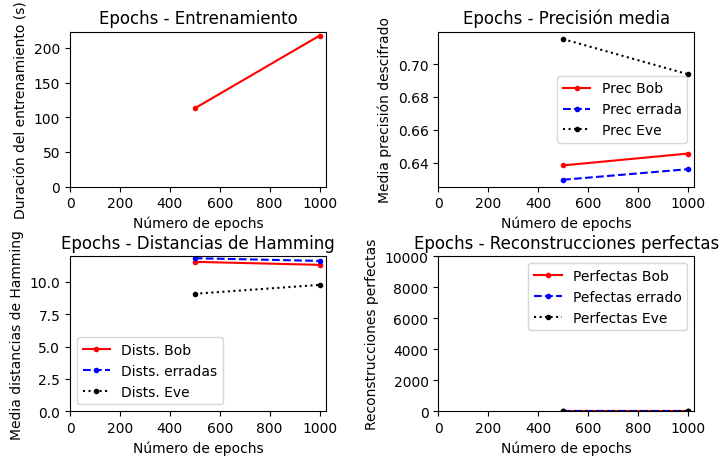

In [36]:
if __name__ == '__main__':

    nombre_figura_base = "Figura 22 - 128 y 0,001 cada 500"
    res_file_name_base = "Resultados_22"

    n_mensajes = 10000 
    bits = 32
    step = 500
    total_epochs = 6000
    batch_size = 128
    adam_optimizer = 0.001
    beta = 2.0
    gamma = 7.0
    muestras = 10

    for i in range(0, 2):
    
        epochs = 500
        if (i == 0):
            res_file_name = res_file_name_base + "_2.txt"
            nombre_figura = nombre_figura_base + ", segunda vez"
        elif (i == 1):
            res_file_name = res_file_name_base + "_3.txt"
            nombre_figura = nombre_figura_base + ", tercera vez"

        with open(res_file_name, "w") as f:
            f.write("-- RESULTADOS DEL EXPERIMENTO 2.2. --\n\n")
    
        with open(res_file_name, "a") as f:
            f.write(f"Número de mensajes = {n_mensajes}\n")
            f.write(f"Número de bits = {bits}\n")
            f.write(f"Tamaño del batch = {batch_size}\n")
            f.write(f"Adam optimizer learning rate = {adam_optimizer}\n")
            f.write(f"Epochs totales = {total_epochs}\n")
            f.write(f"Epochs iniciales = {epochs}\n")
            f.write(f"beta = {beta}\n")
            f.write(f"gamma = {gamma}\n")
        
        diccionario_medidas = {
            "epochs": [],
            "training_times": [],
            "precisiones_bob": [],
            "precisiones_eve": [],
            "distancias_hamming_bob": [],
            "distancias_hamming_eve": [],
            "reconstrucciones_perfectas_bob": [],
            "reconstrucciones_perfectas_eve": [],
            "precisiones_bob_errado": [],
            "distancias_bob_errado": [],
            "reconstrucciones_perfectas_errado": []
        }
        
        time_0 = t.time()
        while epochs <= total_epochs:
            training_time = entrenar(n_mensajes, bits, epochs, batch_size, adam_optimizer, beta, gamma)
            
            res_list = evaluar(n_mensajes, bits, muestras, epochs, res_file_name)

            precisiones_bob = res_list[0]
            precisiones_eve = res_list[1]
            distancias_hamming_bob = res_list[2]
            distancias_hamming_eve = res_list[3]
            reconstrucciones_perfectas_bob = res_list[4]
            reconstrucciones_perfectas_eve = res_list[5]
            precisiones_bob_errado = res_list[6]
            distancias_bob_errado = res_list[7]
            reconstrucciones_perfectas_errado = res_list[8]

            diccionario_medidas["epochs"].append(epochs)
            diccionario_medidas["training_times"].append(training_time)
            
            diccionario_medidas["precisiones_bob"].append(precisiones_bob)
            diccionario_medidas["distancias_hamming_bob"].append(distancias_hamming_bob)
            diccionario_medidas["reconstrucciones_perfectas_bob"].append(reconstrucciones_perfectas_bob)
            
            diccionario_medidas["precisiones_eve"].append(precisiones_eve)
            diccionario_medidas["distancias_hamming_eve"].append(distancias_hamming_eve)
            diccionario_medidas["reconstrucciones_perfectas_eve"].append(reconstrucciones_perfectas_eve)

            diccionario_medidas["precisiones_bob_errado"].append(precisiones_bob_errado)
            diccionario_medidas["distancias_bob_errado"].append(distancias_bob_errado)
            diccionario_medidas["reconstrucciones_perfectas_errado"].append(reconstrucciones_perfectas_errado)

            epochs += step
        
        total_time = t.time() - time_0
        with open(res_file_name, "a") as f:
            f.write(f"\nTiempo total de ejecución (s) = {total_time}\n")
            f.write(f"Tiempo total de ejecución (mins) = {total_time/60}")

        draw_graph(diccionario_medidas, n_mensajes, nombre_figura)

El resultado de la ejecución aparecerá encima de este texto y producirá una imagen al finalizar la ejecución con todos los resultados. Además, la imagen generada con las gráficas también queda guardada en el directorio de esta Jupyter Notebook.

Se anima a jugar con los parámetros, como el tamaño del _batch_, las _epochs_, el _adam optimizer_... para probar el rendimiento en distintos casos. Además, en este escenario se han añadido los hiperparámetros alfa, beta y gamma, que permiten ajustar el funcionamiento de las redes neuronales influyendo en la función de coste/pérdida.